# Staff line recognition

Imports and definitions

In [46]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin_otsu(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return image_bin
def blur(image):
    return cv2.GaussianBlur(image,(5,5),0)
def invert(image):
    return 255-image
def display_image(image, color= False):
    plt.figure()
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
    plt.show()
def dilate(image):
    kernel = np.ones((1,100))
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((1,100))
    return cv2.erode(image, kernel, iterations=1)
def open_image(image):
    return dilate(erode(image))

Image load and binarization

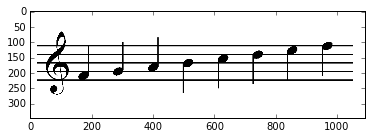

In [2]:
org_image = load_image("staff-with-notes.jpg")
image = image_gray(org_image)
img_otsu = image_bin_otsu(image)
display_image(img_otsu)

Image inversion

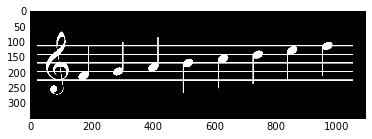

In [3]:
inv_img = invert(img_otsu)
display_image(inv_img)

## Horizontal projection

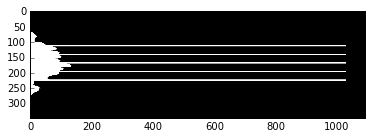

In [4]:
hor_proj = []
for i in range(len(inv_img)):
    row_sum = 0
    for j in range(len(inv_img[i])):
        row_sum += inv_img[i][j] == 255
    hor_proj.append([255] * row_sum + [0] * (len(inv_img[0]) - row_sum))
    
display_image(hor_proj)

Staff line localization. Selects a part of horizontal projection at 2/3 width.

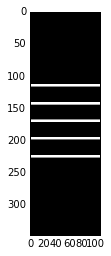

In [5]:
two_thirds = 2 * len(hor_proj[0])//3
cutoff_size = len(hor_proj[0]) // 10
cutoff = hor_proj[:]

for i in range(len(cutoff)):
    cutoff[i] = cutoff[i][two_thirds : two_thirds + cutoff_size] 

cutoff = np.array(cutoff, dtype = np.uint8)
display_image(cutoff)

Finding contours - staff lines.

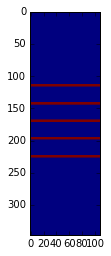

In [6]:
for i in range(len(cutoff))
img_cnt, contours, hierarchy = cv2.findContours(cutoff.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
img_cnt = cutoff.copy()
cv2.drawContours(img_cnt, contours, -1, (255,0,0), 1)
plt.imshow(img_cnt)

Finding tops, bottoms and thicknesses of staff lines, as well as the average staff line thickness.

In [27]:
def find_contours(image):
    img_cnt, contours, hierarchy = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    lines_tops = []
    lines_bottoms = []
    lines_thicknesses = []

    for contour in contours:
        center, size, angle = cv2.minAreaRect(contour)
        xt,yt,w,h = cv2.boundingRect(contour)
        lines_tops.append(yt)
        lines_bottoms.append(yt + h)
        lines_thicknesses.append(h)

    lines_tops = sorted(lines_tops)
    lines_bottoms = sorted(lines_bottoms)
    lines_thicknesses = sorted(lines_thicknesses)
    print("Lines top positions: " + str(lines_tops))
    print("Lines bottom positions: " + str(lines_bottoms))
    print("Lines thicknesses: " + str(lines_thicknesses))

    avg_thickness = sum(lines_thickness) / len(lines_thickness)
    print("Average line thickness: " + str(avg_thickness))
    return lines_tops, lines_bottoms, lines_thicknesses, avg_thickness

def find_all_ys(image):
    ys = []
    for i in range(len(image)):
        for j in range(len(image[i])):
            if (image[i][j] == 255) and (i not in ys):
                ys.append(i)
    print("Y coordinates: " + str(sorted(ys)))
    return sorted(ys)

In [28]:
lines_tops, lines_bottoms, lines_thicknesses, avg_thickness = find_contours(cutoff)
ys = find_all_ys(cutoff)

Lines top positions: [113, 141, 168, 195, 223]
Lines bottom positions: [117, 145, 172, 199, 227]
Lines thicknesses: [4, 4, 4, 4, 4]
Average line thickness: 4
Y coordinates: [113, 114, 115, 116, 141, 142, 143, 144, 168, 169, 170, 171, 195, 196, 197, 198, 223, 224, 225, 226]


## Image opening
Erosion, then dilatation.

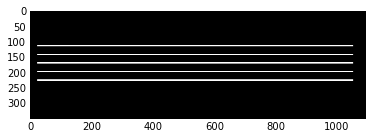

In [11]:
img_opened = open_image(inv_img)
display_image(img_opened)

In [29]:
other_lines_tops, other_lines_bottoms, other_lines_thicknesses, other_avg_thickness = find_contours(img_opened)
other_ys = find_all_ys(img_opened)

Lines top positions: [113, 141, 168, 195, 223]
Lines bottom positions: [117, 145, 172, 199, 227]
Lines thicknesses: [4, 4, 4, 4, 4]
Average line thickness: 4
Y coordinates: [113, 114, 115, 116, 141, 142, 143, 144, 168, 169, 170, 171, 195, 196, 197, 198, 223, 224, 225, 226]


The y-coordinates that are in found in results of both methods are used, in case horizontal projection cutoff gives us a wider lines.

In [33]:
new_ys = []
for y in ys:
    if y in other_ys:
        new_ys += [y]
ys = new_ys

In [45]:
labels = [[]]
line_distances = []
prev_y = None
for y in ys:
    if prev_y is not None:
        if y - prev_y > 1:
            labels.append([])
            line_distances += [y - prev_y]
        labels[-1] += [y]
    prev_y = y
print("Line Y-coords, grouped by lines: " + str(labels))
print("Distances between the lines: " + str(line_distances))

Line Y-coords, grouped by lines: [[114, 115, 116], [141, 142, 143, 144], [168, 169, 170, 171], [195, 196, 197, 198], [223, 224, 225, 226]]
Distances between the lines: [25, 24, 24, 25]
